In the previous section we saw how we could build a simple RAG app that could be used to generate an answer based on the user's query with the help of custom pdf. Now in this section we will see how we can use the same app and evaluate it using the RAG metric provided by the RAGAS library.

Before showing how we can evaluate the RAG app, let's first create a set of questions and ground truth answers to evaluate the model. This will help us to evaluate the RAG Application performance. For the ease and simplicity, we will only use 5 questions and their ground truth answers extracted from the Llama document we just loaded.

In [1]:
questions = [
    "What is the developer of Llama model?",
    "How many versions of Llama model are there?",
    "How is Llama 3 model different from GPT-3?",
    "Can you provide some information about the training datset of Llama-1 model?",
    "What is the context length of Llama 3 model?",
]

ground_truth = [
    "Meta AI is the developer of the Llama model.",
    "There are three versions of the Llama model.",
    "There are minor architectural differences. Compared to GPT-3, LLaMA uses SwiGLU activation function instead of GeLU; uses rotary positional embeddings instead of absolute positional embedding; uses root-mean-squared layer-normalization instead of standard layer-normalization; increases context length to 8k in Llama 3 (compared to 4k in Llama 2 and 2k in Llama 1 and GPT-3)",
    "LLaMA 1 foundational models were trained on a data set with 1.4 trillion tokens, drawn from publicly available data sources, including: Webpages scraped by CommonCrawl; Open source repositories of source code from GitHub; Wikipedia in 20 different languages; Public domain books from Project Gutenberg; Books3 books dataset; The LaTeX source code for scientific papers uploaded to ArXiv; Questions and answers from Stack Exchange websites. On April 17, 2023, TogetherAI launched a project named RedPajama to reproduce and distribute an open source version of the LLaMA dataset. The dataset has approximately 1.2 trillion tokens and is publicly available for download",
    "The context length of Llama 3 model is 8192 tokens.",
]

Great! Now we have the test/evaluation set as well against which we can evaluate the RAG App. Now let's move on to the next step which is properly formatting the evaluation set using the dataset library by huggingface.

In [2]:
from datasets import Dataset

def create_test_case(questions, ground_truth, rag_chain, retriever):
    '''
    This function creates a test case for the RAG model
    It takes a list of questions and the corresponding ground truth answers. 
    It then uses the RAG model to generate answers for the questions.
    It also retrieves the relevant documents for each question.
    Finally, it combines all the information into a dataset object and returns it.

    Args:
        questions: list of strings, questions to be answered
        ground_truth: list of strings, corresponding ground truth answers
        rag_chain: RAG model
        retriever: Retriever object

    Returns:
        dataset: Dataset object containing the questions, answers, contexts and ground truth answers
    '''
    
    data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

    for query in questions:
        data["question"].append(query)
        # data["answer"].append(rag_chain.invoke(query)['result'])
        data["answer"].append(rag_chain.invoke(query))
        data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

    dataset = Dataset.from_dict(data)

    return dataset

For now we will just keep this function to be used later in the evaluation process.

Now let's create a function that will evaluate the RAG App using the RAGAS library.

In [3]:
from ragas import evaluate

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

import nest_asyncio
nest_asyncio.apply()

def evaluate_rag(dataset, llm, embeddings):

    '''
    This function evaluates the RAG model on a dataset using the specified metrics

    Args:
        dataset: Dataset object containing the questions, answers, contexts and ground truth answers
        llm: LLM model
        embeddings: Embeddings object

    Returns:
        result: dictionary containing the evaluation results
    '''
    result = evaluate(
        dataset=dataset,
        llm=llm,
        embeddings=embeddings,
        metrics=[
            context_relevancy, 
            context_precision,
            faithfulness,
            answer_relevancy,
            context_recall,
        ],
        raise_exceptions=True
    )

    return result

Great! It's as simple as that. Now we can evaluate the RAG App using the RAGAS library. Let's move on to the next step which is to see all these steps in action.

Now let's quickly load the LLM model.

In [4]:
from langchain_community.chat_models import ChatOllama

model_id = "llama3:instruct"

llm = ChatOllama(model=model_id)

Now let's choose the embeddings model on which we want to evaluate the RAG App. Here in this blog, we will be using 5 types of embeddings models to evaluate the RAG App. These are: dunzhang/stella_en_1.5B_v5, BAAI/bge-large-en, BAAI/bge-small-en, Salesforce/SFR-Embedding-2_R, Alibaba-NLP/gte-Qwen2-7B-instruct. For more information for each of these embeddings models, you can refer to the Huggingface model hub or go to the MTEB Leaderboard.

In [5]:
embedding_models = ['dunzhang/stella_en_1.5B_v5', 'BAAI/bge-large-en', 'BAAI/bge-small-en', 'Salesforce/SFR-Embedding-2_R', 'Alibaba-NLP/gte-Qwen2-7B-instruct']

Now that we have everything in place, let's tie out all the code from this section as well as the previous section to see how our RAG App performs on the evaluation set.

In [6]:
import sys
sys.path.append('..')

from tqdm.notebook import tqdm
from langchain_huggingface import HuggingFaceEmbeddings

# load the utility functions
from utils import create_chunks_from_pdf, index_documents_and_retrieve, build_rag_chain, evaluate_rag, create_test_case

# define all the parameters
data_path = '../data'
chunk_size = 500
chunk_overlap = 50

# empty lists to store the results
context_relevancy_result, context_precision_result, context_recall_result, faithfulness_result, answer_relevancy_result = [], [], [], [], []

# loop over all the embedding models
for embedding_model_name in tqdm(embedding_models, desc="Embedding Models"):

    # load the embeddings model
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

    docs = create_chunks_from_pdf(data_path, chunk_size, chunk_overlap) # ceate langchain chunked documents
    retriever = index_documents_and_retrieve(docs, embeddings) # index the documents and get the retriever object
    rag_chain = build_rag_chain(llm, retriever) # build the RAG model
    dataset = create_test_case(questions, ground_truth, rag_chain, retriever) # create the test case for each question using each embedding model
    evaluation_result = evaluate_rag(dataset, llm, embeddings) # evaluate the RAG model on the test case

    # store the results
    context_relevancy_result.append(evaluation_result['context_relevancy'])
    context_precision_result.append(evaluation_result['context_precision'])
    context_recall_result.append(evaluation_result['context_recall'])
    faithfulness_result.append(evaluation_result['faithfulness'])
    answer_relevancy_result.append(evaluation_result['answer_relevancy'])

    # print the results to see how the model is performing
    print(f"Embedding Model: {embedding_model_name}")
    for rows in evaluation_result.to_pandas().iterrows():
        print(f"Question: {rows[1]['question']}")
        print(f"Answer: {rows[1]['answer']}")
        print("Ground Truth: ", rows[1]['ground_truth'])
        print(f"Context Relevancy: {rows[1]['context_relevancy']}")
        print(f"Context Precision: {rows[1]['context_precision']}")
        print(f"Faithfulness: {rows[1]['faithfulness']}")
        print(f"Answer Relevancy: {rows[1]['answer_relevancy']}")
        print(f"Context Recall: {rows[1]['context_recall']}")
        print("="*100)
    print("\\_/"*50)

Embedding Models:   0%|          | 0/5 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/home/deepkapha/anaconda3/envs/ai-chatbot/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Embedding Model: dunzhang/stella_en_1.5B_v5
Question: What is the developer of Llama model?
Answer: Based on the provided context, there is no direct mention of the developer of the Llama model. However, it is mentioned that Meta AI's testing shows that Llama 3 (70B) beats Gemini and Claude in most benchmarks. Additionally, Mark Zuckerberg is quoted as stating that the team was surprised by the 70B model's continued learning at the end of training, suggesting that Meta AI may be involved in the development of the Llama model.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.008849557522123894
Context Precision: 0.3333333333
Faithfulness: 0.7142857142857143
Answer Relevancy: 0.0
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: According to the provided context, the question is based on the following text:

"...plans on releasing multimodal models, models capable of conversing in multiple languages, and models with larger c

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Embedding Model: BAAI/bge-large-en
Question: What is the developer of Llama model?
Answer: Based on the provided context, there is no information that directly answers the question "What is the developer of Llama model?" However, I can extract some relevant information.

According to page 5, a software developer named Georgi Gerganov released llama.cpp as open-source on March 10, 2023. This implies that Georgi Gerganov might be involved in developing or re-implementing the Llama model.

However, it's important to note that there is no direct information provided about the original developer of the Llama language model.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.011278195488721804
Context Precision: 0.9999999999666667
Faithfulness: 0.75
Answer Relevancy: 0.0
Context Recall: 0.6666666666666666
Question: How many versions of Llama model are there?
Answer: Based on the provided context, I can see that:

1. Initially, only LLaMA 1 was available as a fou

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Embedding Model: BAAI/bge-small-en
Question: What is the developer of Llama model?
Answer: Based on the provided context, there is no direct mention of the developer of the Llama model. However, it is mentioned that Georgi Gerganov released an open-source implementation of Llama in C++ called "llama.cpp" on March 10, 2023. This might suggest that Gerganov had some involvement or contribution to the development of the Llama model, but it is not explicitly stated.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.011673151750972763
Context Precision: 0.999999999975
Faithfulness: 0.8333333333333334
Answer Relevancy: 0.9882436320170883
Context Recall: 0.5
Question: How many versions of Llama model are there?
Answer: Based on the given context, I can see that:

* There is a mention of "Llama 2" in the document content.
* There is also a mention of "LLaMA-1 models" which suggests that there is at least one previous version of the LLaMA model.

However, it's not

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Embedding Model: Salesforce/SFR-Embedding-2_R
Question: What is the developer of Llama model?
Answer: According to the provided context, the developer(s) of the Llama model are Meta AI.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.018633540372670808
Context Precision: 0.99999999995
Faithfulness: 1.0
Answer Relevancy: 0.9480041718419262
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: Based on the provided context, I can see that there are at least 3 versions of the LLaMA model mentioned:

1. LLaMA (original)
2. LLaMA-2
3. LLaMA-3

Additionally, it's mentioned that there were unauthorized copies shared via BitTorrent, and later on, subsequent versions of LLaMA were made accessible outside academia and released under licenses permitting some commercial use.

So, to answer your question, there are at least 3 named versions of the LLaMA model: LLaMA, LLaMA-2, and LLaMA-3.
Ground Truth:  There are three versions of the Lla

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Embedding Model: Alibaba-NLP/gte-Qwen2-7B-instruct
Question: What is the developer of Llama model?
Answer: Based on the provided context, the developer of the Llama model is Meta.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.005649717514124294
Context Precision: 0.499999999975
Faithfulness: 1.0
Answer Relevancy: 0.8480938578182253
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: Based on the provided context, we can see that there are at least 3 versions of the LLaMA model:

* LLaMA 1
* LLaMA 2
* LLaMA 3

Additionally, it is mentioned that future versions (LLaMA 5, 6, and 7) are planned.
Ground Truth:  There are three versions of the Llama model.
Context Relevancy: 0.01020408163265306
Context Precision: 0.8055555555287036
Faithfulness: 1.0
Answer Relevancy: 0.5249875097848541
Context Recall: 1.0
Question: How is Llama 3 model different from GPT-3?
Answer: According to the provided context, LLaMA 3 uses the following c

Great! Now we have successfully evaluated the RAG App using the RAGAS library. Now let's plot the results to see how the RAG App performs on the evaluation set using different embeddings models.

/tmp/ipykernel_2394656/2711038859.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2394656/2711038859.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2394656/2711038859.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2394656/2711038859.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2394656/2711038859.py:23: UserWarning: set_ticklabels() should only be used with a fixed n

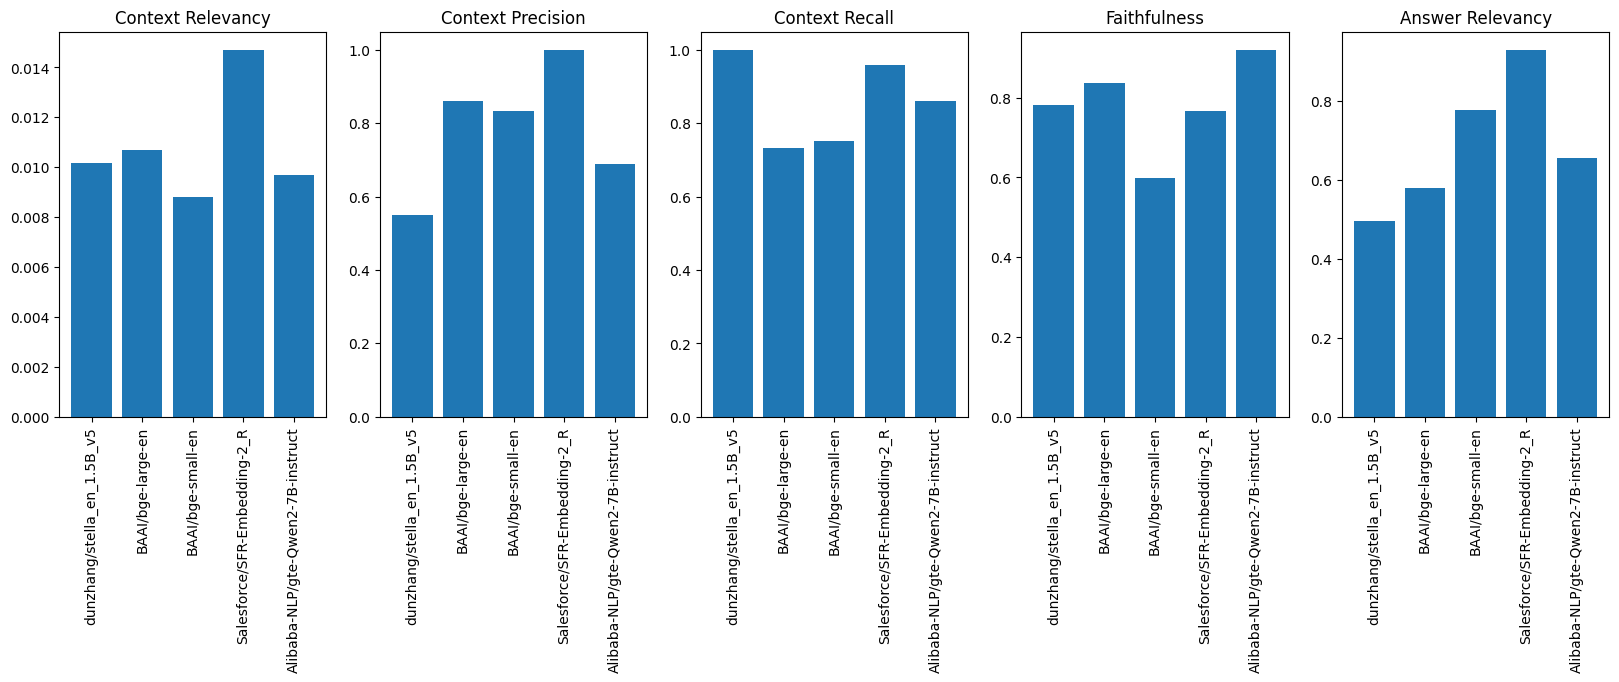

In [7]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].bar(embedding_models, context_relevancy_result)
ax[0].set_title("Context Relevancy")
ax[0].set_xticklabels(embedding_models, rotation=90)

ax[1].bar(embedding_models, context_precision_result)
ax[1].set_title("Context Precision")
ax[1].set_xticklabels(embedding_models, rotation=90)

ax[2].bar(embedding_models, context_recall_result)
ax[2].set_title("Context Recall")
ax[2].set_xticklabels(embedding_models, rotation=90)

ax[3].bar(embedding_models, faithfulness_result)
ax[3].set_title("Faithfulness")
ax[3].set_xticklabels(embedding_models, rotation=90)

ax[4].bar(embedding_models, answer_relevancy_result)
ax[4].set_title("Answer Relevancy")
ax[4].set_xticklabels(embedding_models, rotation=90)

plt.show()

We can see that the embedding model from salesforce has given the best results. So it's essential to choose the right embeddings model for the RAG App to perform well.